<a href="https://colab.research.google.com/github/RPatra2010/Easy21-RL/blob/master/Temporal_Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving environment.py to environment.py


In [0]:
from environment import env
e = env()

In [0]:
N0 = 100

def reset_space():
    #action value function matrix
    Q = np.zeros((22, 11, len(e.actionSpace())))
    #state-action pair counter
    NSA = np.zeros((22, 11, len(e.actionSpace())))
    wins = 0
    
    return Q, NSA, wins

Q, NSA, wins = reset_space()

In [0]:
#number of times a state has been visited
NS = lambda p, d: np.sum(NSA[p, d])

#learning rate
learning_rate = lambda p, d, a: 1/NSA[p, d, a]

#exploration prob
epsilon = lambda p, d: N0/(N0 + NS(p, d))

In [0]:
#exploration policy
def epsilon_greedy(p, d):
    prob = np.random.uniform(0, 1)
    if prob < epsilon(p, d):
        action = np.random.choice(e.actionSpace())
    else:
        action = np.argmax([Q[p, d, a] for a in e.actionSpace()])
    
    return action

In [9]:
#for the true Q values, we use the Q values after Monte Carlo run for 10000 sims
uploaded = files.upload()

Saving Q_MC.csv to Q_MC.csv


In [0]:
true_Q = np.loadtxt("Q_MC.csv", delimiter = ",")
true_Q = true_Q.reshape(22, 11, 2)

In [20]:
#the main agent env interaction loop
episodes = 10000
lmbds = list(np.arange(0, 11)/10)

mse_lambdas = np.zeros((len(lmbds), int(episodes)))
final_mse = np.zeros((len(lmbds)))

for li, lmbd in enumerate(lmbds):
    Q, NSA, wins = reset_space()

    for episode in range(episodes):
        terminated = False

        #Eligibility trace
        E = np.zeros((22, 11, len(e.actionSpace())))
        player, dealer = e.startGame()

        action = epsilon_greedy(player, dealer)
        state_action = []

        while not terminated:
            next_player, next_dealer, reward, terminated = e.step(player, dealer, action)

            if not terminated:
                next_action = epsilon_greedy(next_player, next_dealer)
                td_error = reward + Q[next_player, next_dealer, next_action] - Q[player, dealer, action]
            
            else:
                td_error = reward - Q[player, dealer, action]
            E[player, dealer, action] += 1
            NSA[player, dealer, action] += 1

            state_action.append([player, dealer, action])

            for (p, d, a) in state_action:
                Q[p, d, a] += learning_rate(p, d, a) * td_error * E[p, d, a]
                E[p, d, a] *= lmbd

            if not terminated:
                player, dealer, action = next_player, next_dealer, next_action
            
        if reward == 1:
            wins += 1

        mse = np.sum(np.square(Q - true_Q)) / (21*10*2)

        mse_lambdas[li, episode] = mse

        if episode % 1000 == 0:
            print("lambda ->", lmbd, "Episode ->", episode, "MSE ->", mse, "Wins % ->", wins/(episode + 1))
    
    final_mse[li] = mse
    print("lambda ->", lmbd, "Episode ->", episode, "MSE ->", mse, "Wins % ->", wins/(episode + 1))
    print("------------------")

lambda -> 0.0 Episode -> 0 MSE -> 0.13166771247609782 Wins % -> 0.0
lambda -> 0.0 Episode -> 1000 MSE -> 0.25217010153069475 Wins % -> 0.44555444555444557
lambda -> 0.0 Episode -> 2000 MSE -> 0.16908200550661082 Wins % -> 0.4527736131934033
lambda -> 0.0 Episode -> 3000 MSE -> 0.1305000060332654 Wins % -> 0.4591802732422526
lambda -> 0.0 Episode -> 4000 MSE -> 0.09779617015486185 Wins % -> 0.46138465383654087
lambda -> 0.0 Episode -> 5000 MSE -> 0.08383351081222298 Wins % -> 0.4673065386922616
lambda -> 0.0 Episode -> 6000 MSE -> 0.065187518779185 Wins % -> 0.4679220129978337
lambda -> 0.0 Episode -> 7000 MSE -> 0.059199576406707234 Wins % -> 0.4685044993572347
lambda -> 0.0 Episode -> 8000 MSE -> 0.05929876170766101 Wins % -> 0.4718160229971254
lambda -> 0.0 Episode -> 9000 MSE -> 0.05724820661570504 Wins % -> 0.4711698700144428
lambda -> 0.0 Episode -> 9999 MSE -> 0.05076422045206817 Wins % -> 0.4713
------------------
lambda -> 0.1 Episode -> 0 MSE -> 0.1298891071951229 Wins % -> 0.

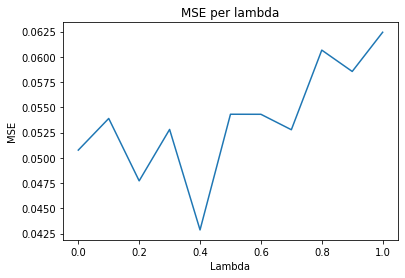

In [22]:
#plot the MSE of different lambdas
plt.plot(lmbds, final_mse)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE per lambda")
plt.show()